In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from google.colab import files
import pickle
import os
import scikitplot as skplt

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/weiteh/miniconda3/envs/datascience/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [2]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [3]:
DATA_DIR="./input/atis"

In [4]:
def load_ds(fname='atis.train.pkl'):
    with open(fname, 'rb') as stream:
        ds,dicts = pickle.load(stream)
    print('Done  loading: ', fname)
    print('      samples: {:4d}'.format(len(ds['query'])))
    print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
    print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
    print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    
    return ds,dicts

In [5]:
def load_atis(filename, add_start_end_token=False, verbose=True):
    train_ds, dicts = load_ds(os.path.join(DATA_DIR,filename))
    t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids'])
    i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
    query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])
    input_tensor = []
    target_tensor = []
    query_data = []
    intent_data = []
    slot_data = []
    to_show = np.random.randint(0, len(query)-1, 5)
    for i in range(len(query)):
        input_tensor.append(query[i])
        slot_text = []
        slot_vector = []
        for j in range(len(query[i])):
            slot_text.append(i2s[slots[i][j]])
            slot_vector.append(slots[i][j])
        target_tensor.append(slot_vector)
        q = ' '.join(map(i2t.get, query[i]))
        query_data.append(q.replace('BOS', 'CLS').replace('EOS','SEP'))
        intent_data.append(i2in[intent[i][0]])
        slot = ' '.join(slot_text)
        slot_data.append(slot[1:-1])
        if i in to_show and verbose:
          print('Query text:', q)
          print('Query vector: ', query[i])
          print('Intent label: ', i2in[intent[i][0]])
          print('Slot text: ', slot)
          print('Slot vector: ', slot_vector)
          print('*'*74)

    query_data = np.array(query_data)
    intent_data = np.array(intent_data)
    slot_data = np.array(slot_data)
    intent_data_label = np.array(intent).flatten()
    return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, \
            query_data, intent_data, intent_data_label, slot_data

In [6]:
# load ATIS training dataset
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
input_tensor_train, target_tensor_train, \
query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')
labels = intent_data_label_train
df = pd.DataFrame({'query': query_data_train, 'intent': intent_data_train, 'slot filling': slot_data_train})
nb_labels = len(df.intent.unique())
labels[labels==14] = -1
labels[labels!=-1] = 0
labels[labels==-1] = 1

Done  loading:  ./input/atis/atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS are there any flights from philadelphia to dallas which stop in atlanta EOS
Query vector:  [178 228 831 218 429 444 678 851 339 920 797 482 242 179]
Intent label:  flight
Slot text:  O O O O O O B-fromloc.city_name O B-toloc.city_name O O O B-stoploc.city_name O
Slot vector:  [128, 128, 128, 128, 128, 128, 48, 128, 78, 128, 128, 128, 71, 128]
**************************************************************************
Query text: BOS what ground transportation is available in denver EOS
Query vector:  [178 916 457 866 498 244 482 351 179]
Intent label:  ground_service
Slot text:  O O O O O O O B-city_name O
Slot vector:  [128, 128, 128, 128, 128, 128, 128, 17, 128]
**************************************************************************
Query text: BOS i would like the cheapest flight from pittsburgh to atlanta leaving april twenty fifth and return

In [8]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in query_data_train]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['cl', '##s', 'i', 'want', 'to', 'fly', 'from', 'boston', 'at', '83', '##8', 'am', 'and', 'arrive', 'in', 'denver', 'at', '111', '##0', 'in', 'the', 'morning', 'sep']


In [9]:
# Set the maximum sequence length. 
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


In [10]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [11]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)


In [12]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [13]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [14]:
# Select a batch size for training. 
batch_size = 32

In [23]:
# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

array([1, 1, 0, ..., 0, 1, 1])

In [17]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [18]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [19]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

In [21]:
len(labels)

4978

In [24]:
# BERT training loop
for _ in trange(epochs, desc="Epoch"):
    ## TRAINING
    # Set our model to training mode
    # Set our model to training mode
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        print(loss)
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Train loss: {}".format(tr_loss/nb_tr_steps)) 
    
    ## VALIDATION

    # Put model in evaluation mode
    model.eval()
    
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))    

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0931, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0345, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward>)
Train loss: 0.012158922851085663


Epoch:  25%|██▌       | 1/4 [00:58<02:55, 58.61s/it]

Validation Accuracy: 0.9867621527777778
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0005, d

tensor(0.0430, device='cuda:0', grad_fn=<NllLossBackward>)
Train loss: 0.007417997218934553


Epoch:  50%|█████     | 2/4 [01:57<01:57, 58.70s/it]

Validation Accuracy: 0.9887152777777778
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0361, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0389, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0088, d

tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward>)
Train loss: 0.010497650178149343


Epoch:  75%|███████▌  | 3/4 [02:56<00:58, 58.78s/it]

Validation Accuracy: 0.9887152777777778
tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0034, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0007, d

tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward>)
Train loss: 0.0035278671753725837


Epoch: 100%|██████████| 4/4 [03:55<00:00, 58.89s/it]

Validation Accuracy: 0.994140625


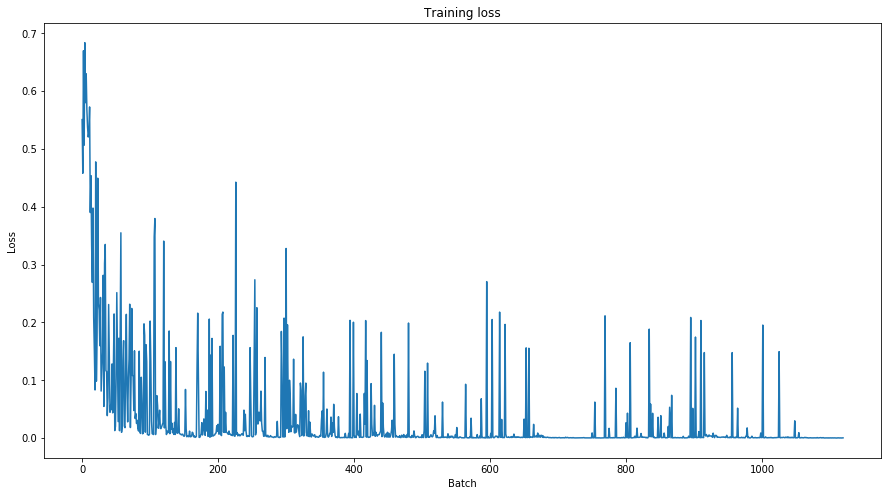

In [25]:
# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [26]:
# load ATIS training dataset
t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, \
input_tensor_test, target_tensor_test, \
query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')
test_labels = intent_data_label_test
test_labels[test_labels==14] = -1
test_labels[test_labels!=-1] = 0
test_labels[test_labels==-1] = 1

Done  loading:  ./input/atis/atis.test.pkl
      samples:  893
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS what is airline wn EOS
Query vector:  [178 916 498 199 928 179]
Intent label:  airline
Slot text:  O O O O B-airline_code O
Slot vector:  [128, 128, 128, 128, 1, 128]
**************************************************************************
Query text: BOS what is the shortest flight from milwaukee to st. petersburg EOS
Query vector:  [178 916 498 827 768 428 444 595 851 789 677 179]
Intent label:  flight
Slot text:  O O O O B-flight_mod O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O
Slot vector:  [128, 128, 128, 128, 42, 128, 128, 48, 128, 78, 125, 128]
**************************************************************************
Query text: BOS show me all nonstop flights from st. petersburg to charlotte EOS
Query vector:  [178 770 581 207 629 429 444 789 677 851 294 179]
Intent label:  flight
Slot text:  O O O O B-flight_stop O O B

In [28]:
# tokenize test data
tokenized_texts = [tokenizer.tokenize(sent) for sent in query_data_test]

In [29]:
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


In [30]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks

In [31]:
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

In [33]:
# create test tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_labels)
batch_size = 32  
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [34]:
## Prediction on test set
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    
        

In [35]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef

matthews_set = []
for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)


/home/weiteh/miniconda3/envs/datascience/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [36]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [37]:
print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))

Classification accuracy using BERT Fine Tuning: 95.94%
